In [3]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(9, 13)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 200
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [5]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [6]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [7]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [8]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [9]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [10]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [11]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [12]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [13]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [14]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [15]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return balance_x, balance_y

In [16]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [17]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [18]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
47768 47768
Train subject 9, class HandStart
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1752/1752 [==============================] - 2s 1ms/step - loss: 0.7581 - acc: 0.6130 - val_loss: 0.6543 - val_acc: 0.6712
Epoch 2/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.6555 - acc: 0.6478 - val_loss: 0.6280 - val_acc: 0.6712
Epoch 3/100
1752/1752 [==============================] - 1s 320us/step - loss: 0.6040 - acc: 0.6804 - val_loss: 0.5849 - val_acc: 0.6986
Epoch 4/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.5804 - acc: 0.6952 - val_loss: 0.5820 - val_acc: 0.7100
Epoch 5/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.5622 - acc: 0.7043 - val_loss: 0.5752 - val_acc: 0.7169
Epoch 6/100
1752/1752 [==============================] - 1s 344us/step - loss: 0.5600 - acc: 0.7123 - val_loss: 0.5729 - val_acc: 0.7169
Epoch

Epoch 57/100
1752/1752 [==============================] - 1s 341us/step - loss: 0.3944 - acc: 0.8208 - val_loss: 0.4100 - val_acc: 0.8151
Epoch 58/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.3998 - acc: 0.8185 - val_loss: 0.3976 - val_acc: 0.8174
Epoch 59/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.3967 - acc: 0.8191 - val_loss: 0.4151 - val_acc: 0.8082
Epoch 60/100
1752/1752 [==============================] - 1s 341us/step - loss: 0.3974 - acc: 0.8151 - val_loss: 0.3863 - val_acc: 0.8356
Epoch 61/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.3865 - acc: 0.8248 - val_loss: 0.3872 - val_acc: 0.8242
Epoch 62/100
1752/1752 [==============================] - 1s 320us/step - loss: 0.3906 - acc: 0.8265 - val_loss: 0.3958 - val_acc: 0.8196
Epoch 63/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.3867 - acc: 0.8253 - val_loss: 0.3940 - val_acc: 0.8219
Epoch 64/100
1752/1752 [==========

1752/1752 [==============================] - 1s 340us/step - loss: 0.3210 - acc: 0.8676 - val_loss: 0.3266 - val_acc: 0.8790
Epoch 17/100
1752/1752 [==============================] - 1s 334us/step - loss: 0.3318 - acc: 0.8653 - val_loss: 0.3222 - val_acc: 0.8744
Epoch 18/100
1752/1752 [==============================] - 1s 346us/step - loss: 0.3333 - acc: 0.8687 - val_loss: 0.3216 - val_acc: 0.8721
Epoch 19/100
1752/1752 [==============================] - 1s 337us/step - loss: 0.3442 - acc: 0.8522 - val_loss: 0.3287 - val_acc: 0.8676
Epoch 20/100
1752/1752 [==============================] - 1s 351us/step - loss: 0.3210 - acc: 0.8636 - val_loss: 0.3162 - val_acc: 0.8767
Epoch 21/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.3236 - acc: 0.8716 - val_loss: 0.3099 - val_acc: 0.8790
Epoch 22/100
1752/1752 [==============================] - 1s 335us/step - loss: 0.3165 - acc: 0.8693 - val_loss: 0.3198 - val_acc: 0.8676
Epoch 23/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 329us/step - loss: 0.2625 - acc: 0.9058 - val_loss: 0.2846 - val_acc: 0.8927
Epoch 76/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.2647 - acc: 0.9024 - val_loss: 0.3056 - val_acc: 0.8790
Epoch 77/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.2740 - acc: 0.8921 - val_loss: 0.2872 - val_acc: 0.8950
Epoch 78/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.2586 - acc: 0.9041 - val_loss: 0.2925 - val_acc: 0.8927
Epoch 79/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.2573 - acc: 0.9047 - val_loss: 0.2938 - val_acc: 0.8813
Epoch 80/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.2633 - acc: 0.8967 - val_loss: 0.2770 - val_acc: 0.8904
Epoch 81/100
1752/1752 [==============================] - 1s 318us/step - loss: 0.2676 - acc: 0.8927 - val_loss: 0.2861 - val_acc: 0.8836
Epoch 82/100
1752/1752 [=======================

1751/1751 [==============================] - 1s 332us/step - loss: 0.1822 - acc: 0.9383 - val_loss: 0.2301 - val_acc: 0.9224
Epoch 34/100
1751/1751 [==============================] - 1s 332us/step - loss: 0.1725 - acc: 0.9377 - val_loss: 0.2161 - val_acc: 0.9338
Epoch 35/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.1743 - acc: 0.9377 - val_loss: 0.2457 - val_acc: 0.9110
Epoch 36/100
1751/1751 [==============================] - 1s 343us/step - loss: 0.1818 - acc: 0.9395 - val_loss: 0.2174 - val_acc: 0.9315
Epoch 37/100
1751/1751 [==============================] - 1s 332us/step - loss: 0.1877 - acc: 0.9366 - val_loss: 0.2280 - val_acc: 0.9178
Epoch 38/100
1751/1751 [==============================] - 1s 325us/step - loss: 0.1663 - acc: 0.9429 - val_loss: 0.2234 - val_acc: 0.9201
Epoch 39/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.1618 - acc: 0.9452 - val_loss: 0.2182 - val_acc: 0.9292
Epoch 40/100
1751/1751 [=======================

1751/1751 [==============================] - 1s 366us/step - loss: 0.1275 - acc: 0.9629 - val_loss: 0.1829 - val_acc: 0.9429
Epoch 93/100
1751/1751 [==============================] - 1s 353us/step - loss: 0.1293 - acc: 0.9572 - val_loss: 0.2087 - val_acc: 0.9338
Epoch 94/100
1751/1751 [==============================] - 1s 365us/step - loss: 0.1208 - acc: 0.9617 - val_loss: 0.1847 - val_acc: 0.9429
Epoch 95/100
1751/1751 [==============================] - 1s 327us/step - loss: 0.1188 - acc: 0.9595 - val_loss: 0.2094 - val_acc: 0.9315
Epoch 96/100
1751/1751 [==============================] - 1s 350us/step - loss: 0.1249 - acc: 0.9640 - val_loss: 0.2037 - val_acc: 0.9315
Epoch 97/100
1751/1751 [==============================] - 1s 364us/step - loss: 0.1287 - acc: 0.9577 - val_loss: 0.1725 - val_acc: 0.9452
Epoch 98/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.1159 - acc: 0.9629 - val_loss: 0.2132 - val_acc: 0.9315
Epoch 99/100
1751/1751 [=======================

Epoch 51/100
1751/1751 [==============================] - 1s 325us/step - loss: 0.1149 - acc: 0.9657 - val_loss: 0.1237 - val_acc: 0.9635
Epoch 52/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.1155 - acc: 0.9663 - val_loss: 0.1345 - val_acc: 0.9612
Epoch 53/100
1751/1751 [==============================] - 1s 336us/step - loss: 0.1158 - acc: 0.9623 - val_loss: 0.1303 - val_acc: 0.9635
Epoch 54/100
1751/1751 [==============================] - 1s 333us/step - loss: 0.1090 - acc: 0.9686 - val_loss: 0.1343 - val_acc: 0.9612
Epoch 55/100
1751/1751 [==============================] - 1s 328us/step - loss: 0.1108 - acc: 0.9629 - val_loss: 0.1262 - val_acc: 0.9635
Epoch 56/100
1751/1751 [==============================] - 1s 330us/step - loss: 0.1044 - acc: 0.9680 - val_loss: 0.1398 - val_acc: 0.9589
Epoch 57/100
1751/1751 [==============================] - 1s 325us/step - loss: 0.1064 - acc: 0.9680 - val_loss: 0.1237 - val_acc: 0.9635
Epoch 58/100
1751/1751 [==========

1752/1752 [==============================] - 1s 330us/step - loss: 0.3306 - acc: 0.8676 - val_loss: 0.3566 - val_acc: 0.8744
Epoch 10/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.3160 - acc: 0.8784 - val_loss: 0.3478 - val_acc: 0.8790
Epoch 11/100
1752/1752 [==============================] - 1s 333us/step - loss: 0.3083 - acc: 0.8836 - val_loss: 0.3416 - val_acc: 0.8836
Epoch 12/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.3025 - acc: 0.8847 - val_loss: 0.3407 - val_acc: 0.8813
Epoch 13/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.2934 - acc: 0.8893 - val_loss: 0.3310 - val_acc: 0.8858
Epoch 14/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.2949 - acc: 0.8944 - val_loss: 0.3219 - val_acc: 0.8904
Epoch 15/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.2857 - acc: 0.8990 - val_loss: 0.3193 - val_acc: 0.8904
Epoch 16/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 335us/step - loss: 0.1436 - acc: 0.9555 - val_loss: 0.1971 - val_acc: 0.9361
Epoch 69/100
1752/1752 [==============================] - 1s 342us/step - loss: 0.1537 - acc: 0.9458 - val_loss: 0.1973 - val_acc: 0.9338
Epoch 70/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.1473 - acc: 0.9475 - val_loss: 0.1958 - val_acc: 0.9361
Epoch 71/100
1752/1752 [==============================] - 1s 346us/step - loss: 0.1484 - acc: 0.9498 - val_loss: 0.1969 - val_acc: 0.9384
Epoch 72/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.1429 - acc: 0.9543 - val_loss: 0.1950 - val_acc: 0.9384
Epoch 73/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.1415 - acc: 0.9532 - val_loss: 0.1959 - val_acc: 0.9361
Epoch 74/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.1502 - acc: 0.9446 - val_loss: 0.1966 - val_acc: 0.9361
Epoch 75/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 367us/step - loss: 0.1572 - acc: 0.9486 - val_loss: 0.1430 - val_acc: 0.9543
Epoch 28/100
1752/1752 [==============================] - 1s 341us/step - loss: 0.1582 - acc: 0.9492 - val_loss: 0.1391 - val_acc: 0.9543
Epoch 29/100
1752/1752 [==============================] - 1s 339us/step - loss: 0.1514 - acc: 0.9543 - val_loss: 0.1412 - val_acc: 0.9566
Epoch 30/100
1752/1752 [==============================] - 1s 348us/step - loss: 0.1609 - acc: 0.9538 - val_loss: 0.1412 - val_acc: 0.9566
Epoch 31/100
1752/1752 [==============================] - 1s 347us/step - loss: 0.1534 - acc: 0.9566 - val_loss: 0.1385 - val_acc: 0.9566
Epoch 32/100
1752/1752 [==============================] - 1s 344us/step - loss: 0.1500 - acc: 0.9526 - val_loss: 0.1453 - val_acc: 0.9566
Epoch 33/100
1752/1752 [==============================] - 1s 348us/step - loss: 0.1530 - acc: 0.9549 - val_loss: 0.1424 - val_acc: 0.9566
Epoch 34/100
1752/1752 [=======================

1752/1752 [==============================] - 1s 328us/step - loss: 0.1260 - acc: 0.9658 - val_loss: 0.1320 - val_acc: 0.9589
Epoch 87/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.1248 - acc: 0.9680 - val_loss: 0.1388 - val_acc: 0.9566
Epoch 88/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.1278 - acc: 0.9618 - val_loss: 0.1443 - val_acc: 0.9566
Epoch 89/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.1292 - acc: 0.9618 - val_loss: 0.1397 - val_acc: 0.9566
Epoch 90/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.1240 - acc: 0.9612 - val_loss: 0.1307 - val_acc: 0.9589
Epoch 91/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.1244 - acc: 0.9600 - val_loss: 0.1330 - val_acc: 0.9566
Epoch 92/100
1752/1752 [==============================] - 1s 322us/step - loss: 0.1231 - acc: 0.9652 - val_loss: 0.1332 - val_acc: 0.9589
Epoch 93/100
1752/1752 [=======================

1751/1751 [==============================] - 1s 324us/step - loss: 0.1710 - acc: 0.9429 - val_loss: 0.2343 - val_acc: 0.9132
Epoch 45/100
1751/1751 [==============================] - 1s 330us/step - loss: 0.1721 - acc: 0.9406 - val_loss: 0.2368 - val_acc: 0.9110
Epoch 46/100
1751/1751 [==============================] - 1s 327us/step - loss: 0.1742 - acc: 0.9332 - val_loss: 0.2306 - val_acc: 0.9132
Epoch 47/100
1751/1751 [==============================] - 1s 328us/step - loss: 0.1741 - acc: 0.9412 - val_loss: 0.2247 - val_acc: 0.9201
Epoch 48/100
1751/1751 [==============================] - 1s 318us/step - loss: 0.1638 - acc: 0.9429 - val_loss: 0.2177 - val_acc: 0.9178
Epoch 49/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.1728 - acc: 0.9463 - val_loss: 0.2320 - val_acc: 0.9132
Epoch 50/100
1751/1751 [==============================] - 1s 321us/step - loss: 0.1674 - acc: 0.9463 - val_loss: 0.2303 - val_acc: 0.9178
Epoch 51/100
1751/1751 [=======================

Epoch 3/100
1751/1751 [==============================] - 1s 324us/step - loss: 0.1736 - acc: 0.9452 - val_loss: 0.1599 - val_acc: 0.9498
Epoch 4/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.1759 - acc: 0.9412 - val_loss: 0.1540 - val_acc: 0.9521
Epoch 5/100
1751/1751 [==============================] - 1s 321us/step - loss: 0.1693 - acc: 0.9480 - val_loss: 0.1528 - val_acc: 0.9521
Epoch 6/100
1751/1751 [==============================] - 1s 325us/step - loss: 0.1531 - acc: 0.9503 - val_loss: 0.1490 - val_acc: 0.9543
Epoch 7/100
1751/1751 [==============================] - 1s 327us/step - loss: 0.1674 - acc: 0.9412 - val_loss: 0.1596 - val_acc: 0.9521
Epoch 8/100
1751/1751 [==============================] - 1s 328us/step - loss: 0.1650 - acc: 0.9486 - val_loss: 0.1530 - val_acc: 0.9543
Epoch 9/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.1648 - acc: 0.9486 - val_loss: 0.1553 - val_acc: 0.9543
Epoch 10/100
1751/1751 [=================

1751/1751 [==============================] - 1s 325us/step - loss: 0.1318 - acc: 0.9612 - val_loss: 0.1415 - val_acc: 0.9566
Epoch 63/100
1751/1751 [==============================] - 1s 321us/step - loss: 0.1277 - acc: 0.9623 - val_loss: 0.1349 - val_acc: 0.9612
Epoch 64/100
1751/1751 [==============================] - 1s 324us/step - loss: 0.1235 - acc: 0.9606 - val_loss: 0.1286 - val_acc: 0.9635
Epoch 65/100
1751/1751 [==============================] - 1s 325us/step - loss: 0.1174 - acc: 0.9657 - val_loss: 0.1312 - val_acc: 0.9635
Epoch 66/100
1751/1751 [==============================] - 1s 326us/step - loss: 0.1202 - acc: 0.9652 - val_loss: 0.1317 - val_acc: 0.9635
Epoch 67/100
1751/1751 [==============================] - 1s 329us/step - loss: 0.1230 - acc: 0.9657 - val_loss: 0.1323 - val_acc: 0.9612
Epoch 68/100
1751/1751 [==============================] - 1s 324us/step - loss: 0.1191 - acc: 0.9646 - val_loss: 0.1311 - val_acc: 0.9635
Epoch 69/100
1751/1751 [=======================

Epoch 21/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.2681 - acc: 0.9053 - val_loss: 0.2250 - val_acc: 0.8995
Epoch 22/100
1752/1752 [==============================] - 1s 318us/step - loss: 0.2512 - acc: 0.9030 - val_loss: 0.2252 - val_acc: 0.9041
Epoch 23/100
1752/1752 [==============================] - 1s 321us/step - loss: 0.2508 - acc: 0.9070 - val_loss: 0.2247 - val_acc: 0.9018
Epoch 24/100
1752/1752 [==============================] - 1s 323us/step - loss: 0.2432 - acc: 0.9087 - val_loss: 0.2188 - val_acc: 0.9110
Epoch 25/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.2400 - acc: 0.9092 - val_loss: 0.2157 - val_acc: 0.9087
Epoch 26/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.2459 - acc: 0.9132 - val_loss: 0.2120 - val_acc: 0.9064
Epoch 27/100
1752/1752 [==============================] - 1s 319us/step - loss: 0.2513 - acc: 0.9075 - val_loss: 0.2118 - val_acc: 0.9110
Epoch 28/100
1752/1752 [==========

1752/1752 [==============================] - 1s 328us/step - loss: 0.1629 - acc: 0.9361 - val_loss: 0.1675 - val_acc: 0.9224
Epoch 81/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.1655 - acc: 0.9372 - val_loss: 0.1683 - val_acc: 0.9224
Epoch 82/100
1752/1752 [==============================] - 1s 322us/step - loss: 0.1646 - acc: 0.9366 - val_loss: 0.1670 - val_acc: 0.9247
Epoch 83/100
1752/1752 [==============================] - 1s 319us/step - loss: 0.1629 - acc: 0.9366 - val_loss: 0.1667 - val_acc: 0.9247
Epoch 84/100
1752/1752 [==============================] - 1s 321us/step - loss: 0.1710 - acc: 0.9361 - val_loss: 0.1665 - val_acc: 0.9247
Epoch 85/100
1752/1752 [==============================] - 1s 320us/step - loss: 0.1624 - acc: 0.9326 - val_loss: 0.1698 - val_acc: 0.9224
Epoch 86/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.1599 - acc: 0.9401 - val_loss: 0.1654 - val_acc: 0.9247
Epoch 87/100
1752/1752 [=======================

Epoch 39/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.1449 - acc: 0.9469 - val_loss: 0.1488 - val_acc: 0.9475
Epoch 40/100
1752/1752 [==============================] - 1s 325us/step - loss: 0.1509 - acc: 0.9446 - val_loss: 0.1471 - val_acc: 0.9498
Epoch 41/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.1444 - acc: 0.9515 - val_loss: 0.1475 - val_acc: 0.9452
Epoch 42/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.1452 - acc: 0.9503 - val_loss: 0.1465 - val_acc: 0.9475
Epoch 43/100
1752/1752 [==============================] - 1s 322us/step - loss: 0.1369 - acc: 0.9521 - val_loss: 0.1448 - val_acc: 0.9475
Epoch 44/100
1752/1752 [==============================] - 1s 327us/step - loss: 0.1391 - acc: 0.9538 - val_loss: 0.1447 - val_acc: 0.9475
Epoch 45/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.1378 - acc: 0.9492 - val_loss: 0.1450 - val_acc: 0.9475
Epoch 46/100
1752/1752 [==========

1752/1752 [==============================] - 1s 327us/step - loss: 0.1101 - acc: 0.9652 - val_loss: 0.1323 - val_acc: 0.9521
Epoch 99/100
1752/1752 [==============================] - 1s 324us/step - loss: 0.1211 - acc: 0.9606 - val_loss: 0.1312 - val_acc: 0.9521
Epoch 100/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.1120 - acc: 0.9640 - val_loss: 0.1304 - val_acc: 0.9475
Test subject 9, class Replace
Train subject 9, class BothReleased
Train on 1752 samples, validate on 438 samples
Epoch 1/100
1752/1752 [==============================] - 1s 513us/step - loss: 0.6308 - acc: 0.7808 - val_loss: 0.5568 - val_acc: 0.7945
Epoch 2/100
1752/1752 [==============================] - 1s 331us/step - loss: 0.4666 - acc: 0.8168 - val_loss: 0.4918 - val_acc: 0.8128
Epoch 3/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.4354 - acc: 0.8185 - val_loss: 0.4445 - val_acc: 0.8219
Epoch 4/100
1752/1752 [==============================] - 1s 333us/step - l

Epoch 57/100
1752/1752 [==============================] - 1s 321us/step - loss: 0.1861 - acc: 0.9332 - val_loss: 0.2193 - val_acc: 0.9201
Epoch 58/100
1752/1752 [==============================] - 1s 341us/step - loss: 0.1915 - acc: 0.9287 - val_loss: 0.2191 - val_acc: 0.9201
Epoch 59/100
1752/1752 [==============================] - 1s 338us/step - loss: 0.1903 - acc: 0.9292 - val_loss: 0.2199 - val_acc: 0.9201
Epoch 60/100
1752/1752 [==============================] - 1s 329us/step - loss: 0.1980 - acc: 0.9258 - val_loss: 0.2173 - val_acc: 0.9224
Epoch 61/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.1900 - acc: 0.9332 - val_loss: 0.2169 - val_acc: 0.9201
Epoch 62/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.1860 - acc: 0.9281 - val_loss: 0.2159 - val_acc: 0.9224
Epoch 63/100
1752/1752 [==============================] - 1s 330us/step - loss: 0.1868 - acc: 0.9298 - val_loss: 0.2172 - val_acc: 0.9224
Epoch 64/100
1752/1752 [==========

Epoch 16/100
1752/1752 [==============================] - 1s 363us/step - loss: 0.1514 - acc: 0.9521 - val_loss: 0.1619 - val_acc: 0.9384
Epoch 17/100
1752/1752 [==============================] - 1s 353us/step - loss: 0.1495 - acc: 0.9486 - val_loss: 0.1629 - val_acc: 0.9384
Epoch 18/100
1752/1752 [==============================] - 1s 354us/step - loss: 0.1504 - acc: 0.9458 - val_loss: 0.1601 - val_acc: 0.9384
Epoch 19/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.1513 - acc: 0.9486 - val_loss: 0.1589 - val_acc: 0.9406
Epoch 20/100
1752/1752 [==============================] - 1s 328us/step - loss: 0.1487 - acc: 0.9475 - val_loss: 0.1632 - val_acc: 0.9384
Epoch 21/100
1752/1752 [==============================] - 1s 326us/step - loss: 0.1497 - acc: 0.9469 - val_loss: 0.1580 - val_acc: 0.9406
Epoch 22/100
1752/1752 [==============================] - 1s 332us/step - loss: 0.1444 - acc: 0.9503 - val_loss: 0.1569 - val_acc: 0.9429
Epoch 23/100
1752/1752 [==========

1752/1752 [==============================] - 1s 344us/step - loss: 0.1173 - acc: 0.9652 - val_loss: 0.1504 - val_acc: 0.9521
Epoch 76/100
1752/1752 [==============================] - 1s 336us/step - loss: 0.1275 - acc: 0.9623 - val_loss: 0.1500 - val_acc: 0.9521
Epoch 77/100
1752/1752 [==============================] - 1s 351us/step - loss: 0.1143 - acc: 0.9623 - val_loss: 0.1507 - val_acc: 0.9498
Epoch 78/100
1752/1752 [==============================] - 1s 344us/step - loss: 0.1195 - acc: 0.9572 - val_loss: 0.1467 - val_acc: 0.9543
Epoch 79/100
1752/1752 [==============================] - 1s 344us/step - loss: 0.1200 - acc: 0.9612 - val_loss: 0.1497 - val_acc: 0.9521
Epoch 80/100
1752/1752 [==============================] - 1s 349us/step - loss: 0.1238 - acc: 0.9612 - val_loss: 0.1474 - val_acc: 0.9543
Epoch 81/100
1752/1752 [==============================] - 1s 357us/step - loss: 0.1244 - acc: 0.9595 - val_loss: 0.1490 - val_acc: 0.9543
Epoch 82/100
1752/1752 [=======================

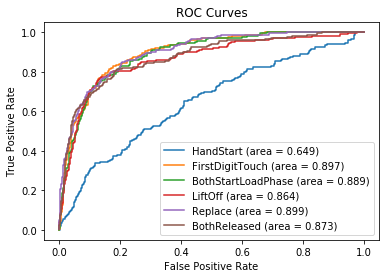

49069 49069
Train subject 10, class HandStart
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 1s 357us/step - loss: 1.1731 - acc: 0.6116 - val_loss: 0.7018 - val_acc: 0.6235
Epoch 2/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.6547 - acc: 0.6348 - val_loss: 0.6618 - val_acc: 0.6440
Epoch 3/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.6243 - acc: 0.6610 - val_loss: 0.6209 - val_acc: 0.6687
Epoch 4/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.6068 - acc: 0.6667 - val_loss: 0.6227 - val_acc: 0.6749
Epoch 5/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.5949 - acc: 0.6831 - val_loss: 0.6201 - val_acc: 0.6728
Epoch 6/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.5712 - acc: 0.6975 - val_loss: 0.6009 - val_acc: 0.6955
Epoch 7/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.5655

Epoch 60/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.4015 - acc: 0.8261 - val_loss: 0.4614 - val_acc: 0.7984
Epoch 61/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.4031 - acc: 0.8158 - val_loss: 0.4760 - val_acc: 0.7860
Epoch 62/100
1944/1944 [==============================] - 1s 323us/step - loss: 0.3972 - acc: 0.8184 - val_loss: 0.4462 - val_acc: 0.8045
Epoch 63/100
1944/1944 [==============================] - 1s 340us/step - loss: 0.3967 - acc: 0.8308 - val_loss: 0.4605 - val_acc: 0.7942
Epoch 64/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.3984 - acc: 0.8128 - val_loss: 0.4599 - val_acc: 0.7984
Epoch 65/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.3954 - acc: 0.8277 - val_loss: 0.4741 - val_acc: 0.7881
Epoch 66/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.3968 - acc: 0.8246 - val_loss: 0.4567 - val_acc: 0.8025
Epoch 67/100
1944/1944 [==========

1944/1944 [==============================] - 1s 331us/step - loss: 0.3438 - acc: 0.8585 - val_loss: 0.3678 - val_acc: 0.8519
Epoch 20/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.3469 - acc: 0.8513 - val_loss: 0.3733 - val_acc: 0.8560
Epoch 21/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.3432 - acc: 0.8647 - val_loss: 0.3756 - val_acc: 0.8498
Epoch 22/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.3549 - acc: 0.8534 - val_loss: 0.3728 - val_acc: 0.8560
Epoch 23/100
1944/1944 [==============================] - 1s 332us/step - loss: 0.3412 - acc: 0.8657 - val_loss: 0.3636 - val_acc: 0.8560
Epoch 24/100
1944/1944 [==============================] - 1s 321us/step - loss: 0.3360 - acc: 0.8678 - val_loss: 0.3792 - val_acc: 0.8560
Epoch 25/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.3385 - acc: 0.8632 - val_loss: 0.3677 - val_acc: 0.8560
Epoch 26/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 327us/step - loss: 0.2883 - acc: 0.8930 - val_loss: 0.3325 - val_acc: 0.8745
Epoch 79/100
1944/1944 [==============================] - 1s 323us/step - loss: 0.2814 - acc: 0.8956 - val_loss: 0.3197 - val_acc: 0.8909
Epoch 80/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.2871 - acc: 0.8884 - val_loss: 0.3265 - val_acc: 0.8745
Epoch 81/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.2762 - acc: 0.8961 - val_loss: 0.3342 - val_acc: 0.8765
Epoch 82/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.2854 - acc: 0.8940 - val_loss: 0.3132 - val_acc: 0.8868
Epoch 83/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.2840 - acc: 0.8961 - val_loss: 0.3171 - val_acc: 0.8868
Epoch 84/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.2878 - acc: 0.8930 - val_loss: 0.3189 - val_acc: 0.8889
Epoch 85/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 345us/step - loss: 0.2037 - acc: 0.9321 - val_loss: 0.2012 - val_acc: 0.9383
Epoch 37/100
1944/1944 [==============================] - 1s 338us/step - loss: 0.2019 - acc: 0.9362 - val_loss: 0.2007 - val_acc: 0.9383
Epoch 38/100
1944/1944 [==============================] - 1s 355us/step - loss: 0.2013 - acc: 0.9372 - val_loss: 0.1983 - val_acc: 0.9383
Epoch 39/100
1944/1944 [==============================] - 1s 344us/step - loss: 0.2056 - acc: 0.9347 - val_loss: 0.1933 - val_acc: 0.9383
Epoch 40/100
1944/1944 [==============================] - 1s 341us/step - loss: 0.2057 - acc: 0.9347 - val_loss: 0.1962 - val_acc: 0.9403
Epoch 41/100
1944/1944 [==============================] - 1s 354us/step - loss: 0.2015 - acc: 0.9357 - val_loss: 0.1924 - val_acc: 0.9383
Epoch 42/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.1926 - acc: 0.9383 - val_loss: 0.1928 - val_acc: 0.9383
Epoch 43/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 339us/step - loss: 0.1538 - acc: 0.9547 - val_loss: 0.1611 - val_acc: 0.9506
Epoch 96/100
1944/1944 [==============================] - 1s 338us/step - loss: 0.1577 - acc: 0.9506 - val_loss: 0.1625 - val_acc: 0.9506
Epoch 97/100
1944/1944 [==============================] - 1s 346us/step - loss: 0.1530 - acc: 0.9516 - val_loss: 0.1690 - val_acc: 0.9527
Epoch 98/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.1578 - acc: 0.9501 - val_loss: 0.1635 - val_acc: 0.9486
Epoch 99/100
1944/1944 [==============================] - 1s 336us/step - loss: 0.1592 - acc: 0.9506 - val_loss: 0.1650 - val_acc: 0.9506
Epoch 100/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.1527 - acc: 0.9511 - val_loss: 0.1648 - val_acc: 0.9527
Train on 1944 samples, validate on 486 samples
Epoch 1/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.2008 - acc: 0.9378 - val_loss: 0.2149 - val_acc: 0.9383


1944/1944 [==============================] - 1s 322us/step - loss: 0.1577 - acc: 0.9522 - val_loss: 0.1914 - val_acc: 0.9444
Epoch 55/100
1944/1944 [==============================] - 1s 335us/step - loss: 0.1479 - acc: 0.9552 - val_loss: 0.1944 - val_acc: 0.9424
Epoch 56/100
1944/1944 [==============================] - 1s 322us/step - loss: 0.1525 - acc: 0.9537 - val_loss: 0.1907 - val_acc: 0.9444
Epoch 57/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1559 - acc: 0.9522 - val_loss: 0.1927 - val_acc: 0.9403
Epoch 58/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1604 - acc: 0.9547 - val_loss: 0.1920 - val_acc: 0.9424
Epoch 59/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1487 - acc: 0.9486 - val_loss: 0.1916 - val_acc: 0.9424
Epoch 60/100
1944/1944 [==============================] - 1s 323us/step - loss: 0.1461 - acc: 0.9568 - val_loss: 0.1893 - val_acc: 0.9424
Epoch 61/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 325us/step - loss: 0.2644 - acc: 0.9084 - val_loss: 0.3360 - val_acc: 0.8868
Epoch 13/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.2664 - acc: 0.9141 - val_loss: 0.3249 - val_acc: 0.8889
Epoch 14/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.2708 - acc: 0.9038 - val_loss: 0.3251 - val_acc: 0.8930
Epoch 15/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.2620 - acc: 0.9115 - val_loss: 0.3255 - val_acc: 0.8765
Epoch 16/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.2580 - acc: 0.9146 - val_loss: 0.3196 - val_acc: 0.8909
Epoch 17/100
1944/1944 [==============================] - 1s 321us/step - loss: 0.2563 - acc: 0.9167 - val_loss: 0.3194 - val_acc: 0.8889
Epoch 18/100
1944/1944 [==============================] - 1s 323us/step - loss: 0.2524 - acc: 0.9151 - val_loss: 0.3222 - val_acc: 0.8889
Epoch 19/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 333us/step - loss: 0.1951 - acc: 0.9414 - val_loss: 0.2629 - val_acc: 0.9136
Epoch 72/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1936 - acc: 0.9398 - val_loss: 0.2561 - val_acc: 0.9136
Epoch 73/100
1944/1944 [==============================] - 1s 323us/step - loss: 0.1993 - acc: 0.9357 - val_loss: 0.2532 - val_acc: 0.9156
Epoch 74/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1892 - acc: 0.9352 - val_loss: 0.2608 - val_acc: 0.9095
Epoch 75/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1865 - acc: 0.9393 - val_loss: 0.2541 - val_acc: 0.9156
Epoch 76/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.1930 - acc: 0.9352 - val_loss: 0.2616 - val_acc: 0.9136
Epoch 77/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1856 - acc: 0.9460 - val_loss: 0.2608 - val_acc: 0.9095
Epoch 78/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 343us/step - loss: 0.1952 - acc: 0.9372 - val_loss: 0.1699 - val_acc: 0.9342
Epoch 31/100
1944/1944 [==============================] - 1s 343us/step - loss: 0.1950 - acc: 0.9372 - val_loss: 0.1635 - val_acc: 0.9383
Epoch 32/100
1944/1944 [==============================] - 1s 350us/step - loss: 0.1876 - acc: 0.9408 - val_loss: 0.1637 - val_acc: 0.9383
Epoch 33/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1826 - acc: 0.9408 - val_loss: 0.1640 - val_acc: 0.9383
Epoch 34/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.1885 - acc: 0.9403 - val_loss: 0.1671 - val_acc: 0.9321
Epoch 35/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.1823 - acc: 0.9383 - val_loss: 0.1577 - val_acc: 0.9424
Epoch 36/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.1849 - acc: 0.9383 - val_loss: 0.1626 - val_acc: 0.9403
Epoch 37/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 325us/step - loss: 0.1592 - acc: 0.9532 - val_loss: 0.1539 - val_acc: 0.9424
Epoch 90/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1583 - acc: 0.9496 - val_loss: 0.1519 - val_acc: 0.9403
Epoch 91/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.1598 - acc: 0.9511 - val_loss: 0.1448 - val_acc: 0.9444
Epoch 92/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1608 - acc: 0.9522 - val_loss: 0.1479 - val_acc: 0.9403
Epoch 93/100
1944/1944 [==============================] - 1s 322us/step - loss: 0.1587 - acc: 0.9542 - val_loss: 0.1460 - val_acc: 0.9403
Epoch 94/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.1552 - acc: 0.9516 - val_loss: 0.1504 - val_acc: 0.9403
Epoch 95/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.1522 - acc: 0.9501 - val_loss: 0.1540 - val_acc: 0.9383
Epoch 96/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 332us/step - loss: 0.2345 - acc: 0.9110 - val_loss: 0.2304 - val_acc: 0.9239
Epoch 48/100
1944/1944 [==============================] - 1s 335us/step - loss: 0.2331 - acc: 0.9156 - val_loss: 0.2224 - val_acc: 0.9259
Epoch 49/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.2353 - acc: 0.9095 - val_loss: 0.2244 - val_acc: 0.9239
Epoch 50/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.2374 - acc: 0.9105 - val_loss: 0.2247 - val_acc: 0.9239
Epoch 51/100
1944/1944 [==============================] - 1s 321us/step - loss: 0.2329 - acc: 0.9115 - val_loss: 0.2224 - val_acc: 0.9239
Epoch 52/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.2304 - acc: 0.9100 - val_loss: 0.2273 - val_acc: 0.9239
Epoch 53/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.2278 - acc: 0.9120 - val_loss: 0.2203 - val_acc: 0.9239
Epoch 54/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 329us/step - loss: 0.2086 - acc: 0.9285 - val_loss: 0.1540 - val_acc: 0.9486
Epoch 7/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.2041 - acc: 0.9342 - val_loss: 0.1535 - val_acc: 0.9486
Epoch 8/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.2048 - acc: 0.9285 - val_loss: 0.1496 - val_acc: 0.9506
Epoch 9/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.2041 - acc: 0.9357 - val_loss: 0.1487 - val_acc: 0.9506
Epoch 10/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.2029 - acc: 0.9275 - val_loss: 0.1502 - val_acc: 0.9506
Epoch 11/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.1992 - acc: 0.9316 - val_loss: 0.1482 - val_acc: 0.9547
Epoch 12/100
1944/1944 [==============================] - 1s 335us/step - loss: 0.2050 - acc: 0.9300 - val_loss: 0.1515 - val_acc: 0.9444
Epoch 13/100
1944/1944 [==========================

1944/1944 [==============================] - 1s 331us/step - loss: 0.1739 - acc: 0.9434 - val_loss: 0.1281 - val_acc: 0.9547
Epoch 66/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.1721 - acc: 0.9444 - val_loss: 0.1292 - val_acc: 0.9547
Epoch 67/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.1744 - acc: 0.9419 - val_loss: 0.1297 - val_acc: 0.9547
Epoch 68/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1724 - acc: 0.9434 - val_loss: 0.1282 - val_acc: 0.9609
Epoch 69/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1698 - acc: 0.9434 - val_loss: 0.1315 - val_acc: 0.9547
Epoch 70/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.1658 - acc: 0.9501 - val_loss: 0.1299 - val_acc: 0.9568
Epoch 71/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1721 - acc: 0.9424 - val_loss: 0.1359 - val_acc: 0.9527
Epoch 72/100
1944/1944 [=======================

Epoch 24/100
1943/1943 [==============================] - 1s 325us/step - loss: 0.2502 - acc: 0.8955 - val_loss: 0.2775 - val_acc: 0.8868
Epoch 25/100
1943/1943 [==============================] - 1s 326us/step - loss: 0.2551 - acc: 0.8929 - val_loss: 0.2660 - val_acc: 0.8909
Epoch 26/100
1943/1943 [==============================] - 1s 328us/step - loss: 0.2552 - acc: 0.8888 - val_loss: 0.2608 - val_acc: 0.8930
Epoch 27/100
1943/1943 [==============================] - 1s 327us/step - loss: 0.2566 - acc: 0.8919 - val_loss: 0.2635 - val_acc: 0.8971
Epoch 28/100
1943/1943 [==============================] - 1s 327us/step - loss: 0.2507 - acc: 0.8966 - val_loss: 0.2618 - val_acc: 0.8951
Epoch 29/100
1943/1943 [==============================] - 1s 329us/step - loss: 0.2449 - acc: 0.9002 - val_loss: 0.2605 - val_acc: 0.8951
Epoch 30/100
1943/1943 [==============================] - 1s 326us/step - loss: 0.2481 - acc: 0.8976 - val_loss: 0.2502 - val_acc: 0.9053
Epoch 31/100
1943/1943 [==========

1943/1943 [==============================] - 1s 330us/step - loss: 0.1782 - acc: 0.9310 - val_loss: 0.2077 - val_acc: 0.9177
Epoch 84/100
1943/1943 [==============================] - 1s 323us/step - loss: 0.1758 - acc: 0.9305 - val_loss: 0.2036 - val_acc: 0.9239
Epoch 85/100
1943/1943 [==============================] - 1s 318us/step - loss: 0.1769 - acc: 0.9352 - val_loss: 0.2020 - val_acc: 0.9259
Epoch 86/100
1943/1943 [==============================] - 1s 324us/step - loss: 0.1790 - acc: 0.9341 - val_loss: 0.2002 - val_acc: 0.9239
Epoch 87/100
1943/1943 [==============================] - 1s 326us/step - loss: 0.1796 - acc: 0.9336 - val_loss: 0.1954 - val_acc: 0.9300
Epoch 88/100
1943/1943 [==============================] - 1s 330us/step - loss: 0.1758 - acc: 0.9315 - val_loss: 0.1948 - val_acc: 0.9321
Epoch 89/100
1943/1943 [==============================] - 1s 320us/step - loss: 0.1804 - acc: 0.9357 - val_loss: 0.2146 - val_acc: 0.9156
Epoch 90/100
1943/1943 [=======================

1943/1943 [==============================] - 1s 326us/step - loss: 0.1571 - acc: 0.9460 - val_loss: 0.1588 - val_acc: 0.9424
Epoch 43/100
1943/1943 [==============================] - 1s 319us/step - loss: 0.1604 - acc: 0.9388 - val_loss: 0.1593 - val_acc: 0.9444
Epoch 44/100
1943/1943 [==============================] - 1s 322us/step - loss: 0.1525 - acc: 0.9449 - val_loss: 0.1573 - val_acc: 0.9486
Epoch 45/100
1943/1943 [==============================] - 1s 325us/step - loss: 0.1597 - acc: 0.9418 - val_loss: 0.1614 - val_acc: 0.9383
Epoch 46/100
1943/1943 [==============================] - 1s 321us/step - loss: 0.1621 - acc: 0.9434 - val_loss: 0.1604 - val_acc: 0.9403
Epoch 47/100
1943/1943 [==============================] - 1s 324us/step - loss: 0.1533 - acc: 0.9470 - val_loss: 0.1626 - val_acc: 0.9383
Epoch 48/100
1943/1943 [==============================] - 1s 319us/step - loss: 0.1500 - acc: 0.9470 - val_loss: 0.1576 - val_acc: 0.9444
Epoch 49/100
1943/1943 [=======================

1944/1944 [==============================] - 1s 333us/step - loss: 0.5854 - acc: 0.7665 - val_loss: 0.5898 - val_acc: 0.7654
Epoch 2/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.4726 - acc: 0.7984 - val_loss: 0.5374 - val_acc: 0.7757
Epoch 3/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.4295 - acc: 0.8153 - val_loss: 0.4986 - val_acc: 0.7984
Epoch 4/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.3762 - acc: 0.8416 - val_loss: 0.4615 - val_acc: 0.8004
Epoch 5/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.3636 - acc: 0.8426 - val_loss: 0.4544 - val_acc: 0.8045
Epoch 6/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.3535 - acc: 0.8560 - val_loss: 0.4532 - val_acc: 0.8148
Epoch 7/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.3388 - acc: 0.8529 - val_loss: 0.4247 - val_acc: 0.8210
Epoch 8/100
1944/1944 [==============================

1944/1944 [==============================] - 1s 324us/step - loss: 0.1936 - acc: 0.9270 - val_loss: 0.3364 - val_acc: 0.8786
Epoch 61/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1961 - acc: 0.9306 - val_loss: 0.3340 - val_acc: 0.8807
Epoch 62/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1999 - acc: 0.9280 - val_loss: 0.3163 - val_acc: 0.8868
Epoch 63/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.1930 - acc: 0.9290 - val_loss: 0.3229 - val_acc: 0.8889
Epoch 64/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.1941 - acc: 0.9352 - val_loss: 0.3237 - val_acc: 0.8889
Epoch 65/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1974 - acc: 0.9254 - val_loss: 0.3149 - val_acc: 0.8909
Epoch 66/100
1944/1944 [==============================] - 1s 322us/step - loss: 0.1894 - acc: 0.9295 - val_loss: 0.3233 - val_acc: 0.8889
Epoch 67/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 344us/step - loss: 0.1811 - acc: 0.9316 - val_loss: 0.2068 - val_acc: 0.9342
Epoch 20/100
1944/1944 [==============================] - 1s 338us/step - loss: 0.1908 - acc: 0.9311 - val_loss: 0.2095 - val_acc: 0.9300
Epoch 21/100
1944/1944 [==============================] - 1s 342us/step - loss: 0.1885 - acc: 0.9331 - val_loss: 0.2062 - val_acc: 0.9300
Epoch 22/100
1944/1944 [==============================] - 1s 336us/step - loss: 0.1885 - acc: 0.9367 - val_loss: 0.2085 - val_acc: 0.9300
Epoch 23/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.1839 - acc: 0.9326 - val_loss: 0.2084 - val_acc: 0.9300
Epoch 24/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.1868 - acc: 0.9342 - val_loss: 0.2055 - val_acc: 0.9321
Epoch 25/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1882 - acc: 0.9300 - val_loss: 0.2073 - val_acc: 0.9300
Epoch 26/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 327us/step - loss: 0.1583 - acc: 0.9419 - val_loss: 0.1902 - val_acc: 0.9362
Epoch 79/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1599 - acc: 0.9450 - val_loss: 0.1888 - val_acc: 0.9383
Epoch 80/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1580 - acc: 0.9455 - val_loss: 0.1870 - val_acc: 0.9383
Epoch 81/100
1944/1944 [==============================] - 1s 334us/step - loss: 0.1597 - acc: 0.9414 - val_loss: 0.1836 - val_acc: 0.9424
Epoch 82/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1590 - acc: 0.9439 - val_loss: 0.1837 - val_acc: 0.9424
Epoch 83/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.1529 - acc: 0.9486 - val_loss: 0.1834 - val_acc: 0.9424
Epoch 84/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.1510 - acc: 0.9475 - val_loss: 0.1843 - val_acc: 0.9444
Epoch 85/100
1944/1944 [=======================

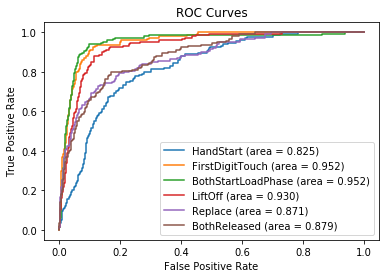

50195 50195
Train subject 11, class HandStart
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 1s 435us/step - loss: 1.1368 - acc: 0.5138 - val_loss: 0.8226 - val_acc: 0.5174
Epoch 2/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.7507 - acc: 0.5486 - val_loss: 0.7114 - val_acc: 0.5767
Epoch 3/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.7071 - acc: 0.5588 - val_loss: 0.6866 - val_acc: 0.5808
Epoch 4/100
1956/1956 [==============================] - 1s 322us/step - loss: 0.6944 - acc: 0.5619 - val_loss: 0.6734 - val_acc: 0.5869
Epoch 5/100
1956/1956 [==============================] - 1s 318us/step - loss: 0.6857 - acc: 0.5624 - val_loss: 0.6647 - val_acc: 0.6053
Epoch 6/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.6759 - acc: 0.5675 - val_loss: 0.6614 - val_acc: 0.6033
Epoch 7/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.6567

Epoch 60/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.4903 - acc: 0.7623 - val_loss: 0.5529 - val_acc: 0.7117
Epoch 61/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.4919 - acc: 0.7669 - val_loss: 0.5418 - val_acc: 0.7178
Epoch 62/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.4925 - acc: 0.7423 - val_loss: 0.6174 - val_acc: 0.6748
Epoch 63/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.4861 - acc: 0.7648 - val_loss: 0.5488 - val_acc: 0.7157
Epoch 64/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.4749 - acc: 0.7720 - val_loss: 0.5828 - val_acc: 0.6851
Epoch 65/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.4791 - acc: 0.7618 - val_loss: 0.5621 - val_acc: 0.7035
Epoch 66/100
1956/1956 [==============================] - 1s 335us/step - loss: 0.4660 - acc: 0.7827 - val_loss: 0.5436 - val_acc: 0.7239
Epoch 67/100
1956/1956 [==========

1956/1956 [==============================] - 1s 329us/step - loss: 0.4224 - acc: 0.8083 - val_loss: 0.4566 - val_acc: 0.7894
Epoch 20/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.4129 - acc: 0.8149 - val_loss: 0.5386 - val_acc: 0.7526
Epoch 21/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.4143 - acc: 0.8124 - val_loss: 0.4333 - val_acc: 0.8057
Epoch 22/100
1956/1956 [==============================] - 1s 337us/step - loss: 0.4104 - acc: 0.8236 - val_loss: 0.4213 - val_acc: 0.8119
Epoch 23/100
1956/1956 [==============================] - 1s 348us/step - loss: 0.4106 - acc: 0.8144 - val_loss: 0.4581 - val_acc: 0.7873
Epoch 24/100
1956/1956 [==============================] - 1s 335us/step - loss: 0.4136 - acc: 0.8144 - val_loss: 0.4263 - val_acc: 0.8139
Epoch 25/100
1956/1956 [==============================] - 1s 337us/step - loss: 0.4105 - acc: 0.8185 - val_loss: 0.4502 - val_acc: 0.7914
Epoch 26/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 329us/step - loss: 0.3413 - acc: 0.8563 - val_loss: 0.3993 - val_acc: 0.8344
Epoch 79/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.3329 - acc: 0.8691 - val_loss: 0.3807 - val_acc: 0.8466
Epoch 80/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.3318 - acc: 0.8696 - val_loss: 0.4048 - val_acc: 0.8303
Epoch 81/100
1956/1956 [==============================] - 1s 342us/step - loss: 0.3379 - acc: 0.8635 - val_loss: 0.3838 - val_acc: 0.8405
Epoch 82/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.3296 - acc: 0.8778 - val_loss: 0.4006 - val_acc: 0.8241
Epoch 83/100
1956/1956 [==============================] - 1s 338us/step - loss: 0.3252 - acc: 0.8691 - val_loss: 0.3555 - val_acc: 0.8569
Epoch 84/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.3197 - acc: 0.8686 - val_loss: 0.4180 - val_acc: 0.8180
Epoch 85/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 332us/step - loss: 0.3432 - acc: 0.8548 - val_loss: 0.4023 - val_acc: 0.8364
Epoch 37/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.3353 - acc: 0.8466 - val_loss: 0.3900 - val_acc: 0.8446
Epoch 38/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.3240 - acc: 0.8599 - val_loss: 0.3888 - val_acc: 0.8466
Epoch 39/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.3240 - acc: 0.8517 - val_loss: 0.3798 - val_acc: 0.8487
Epoch 40/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.3269 - acc: 0.8548 - val_loss: 0.3747 - val_acc: 0.8466
Epoch 41/100
1956/1956 [==============================] - 1s 336us/step - loss: 0.3144 - acc: 0.8615 - val_loss: 0.3688 - val_acc: 0.8466
Epoch 42/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.3131 - acc: 0.8661 - val_loss: 0.3605 - val_acc: 0.8548
Epoch 43/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 332us/step - loss: 0.2166 - acc: 0.9223 - val_loss: 0.2762 - val_acc: 0.9018
Epoch 96/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.2099 - acc: 0.9218 - val_loss: 0.2958 - val_acc: 0.8978
Epoch 97/100
1956/1956 [==============================] - 1s 335us/step - loss: 0.2239 - acc: 0.9121 - val_loss: 0.2807 - val_acc: 0.8978
Epoch 98/100
1956/1956 [==============================] - 1s 341us/step - loss: 0.2162 - acc: 0.9223 - val_loss: 0.2974 - val_acc: 0.8937
Epoch 99/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.2073 - acc: 0.9141 - val_loss: 0.2672 - val_acc: 0.9121
Epoch 100/100
1956/1956 [==============================] - 1s 336us/step - loss: 0.2185 - acc: 0.9167 - val_loss: 0.2680 - val_acc: 0.9039
Train on 1956 samples, validate on 489 samples
Epoch 1/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.2762 - acc: 0.8926 - val_loss: 0.2930 - val_acc: 0.9162


1956/1956 [==============================] - 1s 328us/step - loss: 0.2043 - acc: 0.9289 - val_loss: 0.2617 - val_acc: 0.9223
Epoch 55/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.2008 - acc: 0.9366 - val_loss: 0.2554 - val_acc: 0.9284
Epoch 56/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.1974 - acc: 0.9315 - val_loss: 0.2543 - val_acc: 0.9264
Epoch 57/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.2014 - acc: 0.9361 - val_loss: 0.2474 - val_acc: 0.9284
Epoch 58/100
1956/1956 [==============================] - 1s 336us/step - loss: 0.1885 - acc: 0.9346 - val_loss: 0.2696 - val_acc: 0.9182
Epoch 59/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.1924 - acc: 0.9320 - val_loss: 0.2565 - val_acc: 0.9264
Epoch 60/100
1956/1956 [==============================] - 1s 337us/step - loss: 0.1902 - acc: 0.9340 - val_loss: 0.2438 - val_acc: 0.9325
Epoch 61/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 324us/step - loss: 0.4252 - acc: 0.8027 - val_loss: 0.3931 - val_acc: 0.8364
Epoch 13/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.4240 - acc: 0.8027 - val_loss: 0.3890 - val_acc: 0.8425
Epoch 14/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.4198 - acc: 0.8037 - val_loss: 0.3969 - val_acc: 0.8364
Epoch 15/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.4035 - acc: 0.8124 - val_loss: 0.3910 - val_acc: 0.8446
Epoch 16/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.4028 - acc: 0.8129 - val_loss: 0.3759 - val_acc: 0.8528
Epoch 17/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.3916 - acc: 0.8252 - val_loss: 0.3743 - val_acc: 0.8487
Epoch 18/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.3970 - acc: 0.8252 - val_loss: 0.3643 - val_acc: 0.8630
Epoch 19/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 328us/step - loss: 0.2603 - acc: 0.8962 - val_loss: 0.2722 - val_acc: 0.8937
Epoch 72/100
1956/1956 [==============================] - 1s 332us/step - loss: 0.2538 - acc: 0.9080 - val_loss: 0.2913 - val_acc: 0.8896
Epoch 73/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.2501 - acc: 0.9116 - val_loss: 0.2704 - val_acc: 0.8937
Epoch 74/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.2574 - acc: 0.9034 - val_loss: 0.2735 - val_acc: 0.8957
Epoch 75/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.2497 - acc: 0.9080 - val_loss: 0.2663 - val_acc: 0.8978
Epoch 76/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.2423 - acc: 0.9126 - val_loss: 0.2709 - val_acc: 0.8998
Epoch 77/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.2384 - acc: 0.9116 - val_loss: 0.2628 - val_acc: 0.8978
Epoch 78/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 329us/step - loss: 0.1903 - acc: 0.9315 - val_loss: 0.3303 - val_acc: 0.8875
Epoch 31/100
1956/1956 [==============================] - 1s 337us/step - loss: 0.1969 - acc: 0.9315 - val_loss: 0.3317 - val_acc: 0.8855
Epoch 32/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.1933 - acc: 0.9305 - val_loss: 0.3236 - val_acc: 0.8916
Epoch 33/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.1836 - acc: 0.9340 - val_loss: 0.3202 - val_acc: 0.8937
Epoch 34/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.1997 - acc: 0.9305 - val_loss: 0.3318 - val_acc: 0.8937
Epoch 35/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1833 - acc: 0.9397 - val_loss: 0.3531 - val_acc: 0.8814
Epoch 36/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.1904 - acc: 0.9320 - val_loss: 0.3270 - val_acc: 0.8916
Epoch 37/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 336us/step - loss: 0.1378 - acc: 0.9586 - val_loss: 0.3227 - val_acc: 0.8957
Epoch 90/100
1956/1956 [==============================] - 1s 338us/step - loss: 0.1437 - acc: 0.9514 - val_loss: 0.3398 - val_acc: 0.8937
Epoch 91/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.1473 - acc: 0.9489 - val_loss: 0.3009 - val_acc: 0.8957
Epoch 92/100
1956/1956 [==============================] - 1s 337us/step - loss: 0.1348 - acc: 0.9591 - val_loss: 0.3194 - val_acc: 0.8937
Epoch 93/100
1956/1956 [==============================] - 1s 332us/step - loss: 0.1400 - acc: 0.9530 - val_loss: 0.3145 - val_acc: 0.8937
Epoch 94/100
1956/1956 [==============================] - 1s 346us/step - loss: 0.1323 - acc: 0.9560 - val_loss: 0.3169 - val_acc: 0.8937
Epoch 95/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.1349 - acc: 0.9560 - val_loss: 0.3171 - val_acc: 0.8957
Epoch 96/100
1956/1956 [=======================

1955/1955 [==============================] - 1s 338us/step - loss: 0.3180 - acc: 0.8685 - val_loss: 0.3589 - val_acc: 0.8569
Epoch 48/100
1955/1955 [==============================] - 1s 344us/step - loss: 0.3236 - acc: 0.8670 - val_loss: 0.3665 - val_acc: 0.8548
Epoch 49/100
1955/1955 [==============================] - 1s 359us/step - loss: 0.3132 - acc: 0.8701 - val_loss: 0.3560 - val_acc: 0.8446
Epoch 50/100
1955/1955 [==============================] - 1s 345us/step - loss: 0.3188 - acc: 0.8737 - val_loss: 0.3532 - val_acc: 0.8466
Epoch 51/100
1955/1955 [==============================] - 1s 347us/step - loss: 0.3184 - acc: 0.8762 - val_loss: 0.3485 - val_acc: 0.8487
Epoch 52/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.3179 - acc: 0.8624 - val_loss: 0.3690 - val_acc: 0.8589
Epoch 53/100
1955/1955 [==============================] - 1s 354us/step - loss: 0.3104 - acc: 0.8783 - val_loss: 0.3519 - val_acc: 0.8609
Epoch 54/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 340us/step - loss: 0.2843 - acc: 0.8987 - val_loss: 0.2671 - val_acc: 0.9039
Epoch 7/100
1955/1955 [==============================] - 1s 348us/step - loss: 0.2887 - acc: 0.8885 - val_loss: 0.2576 - val_acc: 0.9100
Epoch 8/100
1955/1955 [==============================] - 1s 346us/step - loss: 0.2839 - acc: 0.8941 - val_loss: 0.2709 - val_acc: 0.9059
Epoch 9/100
1955/1955 [==============================] - 1s 349us/step - loss: 0.2678 - acc: 0.9049 - val_loss: 0.2830 - val_acc: 0.8834
Epoch 10/100
1955/1955 [==============================] - 1s 354us/step - loss: 0.2829 - acc: 0.8936 - val_loss: 0.2746 - val_acc: 0.9039
Epoch 11/100
1955/1955 [==============================] - 1s 338us/step - loss: 0.2769 - acc: 0.8967 - val_loss: 0.2559 - val_acc: 0.8978
Epoch 12/100
1955/1955 [==============================] - 1s 345us/step - loss: 0.2827 - acc: 0.8921 - val_loss: 0.2663 - val_acc: 0.9100
Epoch 13/100
1955/1955 [==========================

1955/1955 [==============================] - 1s 344us/step - loss: 0.1976 - acc: 0.9350 - val_loss: 0.2041 - val_acc: 0.9407
Epoch 66/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.2046 - acc: 0.9350 - val_loss: 0.2278 - val_acc: 0.9223
Epoch 67/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.2046 - acc: 0.9320 - val_loss: 0.2000 - val_acc: 0.9346
Epoch 68/100
1955/1955 [==============================] - 1s 341us/step - loss: 0.2069 - acc: 0.9304 - val_loss: 0.2096 - val_acc: 0.9366
Epoch 69/100
1955/1955 [==============================] - 1s 368us/step - loss: 0.2014 - acc: 0.9335 - val_loss: 0.2090 - val_acc: 0.9407
Epoch 70/100
1955/1955 [==============================] - 1s 341us/step - loss: 0.2106 - acc: 0.9258 - val_loss: 0.2080 - val_acc: 0.9407
Epoch 71/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.1960 - acc: 0.9417 - val_loss: 0.2093 - val_acc: 0.9366
Epoch 72/100
1955/1955 [=======================

Epoch 24/100
1943/1943 [==============================] - 1s 327us/step - loss: 0.2712 - acc: 0.8837 - val_loss: 0.2897 - val_acc: 0.8765
Epoch 25/100
1943/1943 [==============================] - 1s 326us/step - loss: 0.2650 - acc: 0.8893 - val_loss: 0.2877 - val_acc: 0.8765
Epoch 26/100
1943/1943 [==============================] - 1s 330us/step - loss: 0.2662 - acc: 0.8919 - val_loss: 0.2864 - val_acc: 0.8786
Epoch 27/100
1943/1943 [==============================] - 1s 332us/step - loss: 0.2654 - acc: 0.8893 - val_loss: 0.2829 - val_acc: 0.8765
Epoch 28/100
1943/1943 [==============================] - 1s 325us/step - loss: 0.2587 - acc: 0.8971 - val_loss: 0.2792 - val_acc: 0.8786
Epoch 29/100
1943/1943 [==============================] - 1s 328us/step - loss: 0.2522 - acc: 0.8945 - val_loss: 0.2736 - val_acc: 0.8807
Epoch 30/100
1943/1943 [==============================] - 1s 318us/step - loss: 0.2572 - acc: 0.8976 - val_loss: 0.2778 - val_acc: 0.8786
Epoch 31/100
1943/1943 [==========

1943/1943 [==============================] - 1s 325us/step - loss: 0.1919 - acc: 0.9300 - val_loss: 0.2373 - val_acc: 0.9012
Epoch 84/100
1943/1943 [==============================] - 1s 331us/step - loss: 0.1893 - acc: 0.9213 - val_loss: 0.2353 - val_acc: 0.9033
Epoch 85/100
1943/1943 [==============================] - 1s 321us/step - loss: 0.1850 - acc: 0.9279 - val_loss: 0.2341 - val_acc: 0.9012
Epoch 86/100
1943/1943 [==============================] - 1s 325us/step - loss: 0.1848 - acc: 0.9331 - val_loss: 0.2325 - val_acc: 0.9033
Epoch 87/100
1943/1943 [==============================] - 1s 331us/step - loss: 0.1977 - acc: 0.9269 - val_loss: 0.2323 - val_acc: 0.8992
Epoch 88/100
1943/1943 [==============================] - 1s 332us/step - loss: 0.1844 - acc: 0.9233 - val_loss: 0.2302 - val_acc: 0.9074
Epoch 89/100
1943/1943 [==============================] - 1s 328us/step - loss: 0.1901 - acc: 0.9274 - val_loss: 0.2312 - val_acc: 0.9012
Epoch 90/100
1943/1943 [=======================

1943/1943 [==============================] - 1s 329us/step - loss: 0.1658 - acc: 0.9367 - val_loss: 0.1693 - val_acc: 0.9342
Epoch 43/100
1943/1943 [==============================] - 1s 321us/step - loss: 0.1682 - acc: 0.9310 - val_loss: 0.1701 - val_acc: 0.9342
Epoch 44/100
1943/1943 [==============================] - 1s 329us/step - loss: 0.1697 - acc: 0.9295 - val_loss: 0.1701 - val_acc: 0.9342
Epoch 45/100
1943/1943 [==============================] - 1s 335us/step - loss: 0.1642 - acc: 0.9408 - val_loss: 0.1680 - val_acc: 0.9342
Epoch 46/100
1943/1943 [==============================] - 1s 340us/step - loss: 0.1692 - acc: 0.9434 - val_loss: 0.1693 - val_acc: 0.9342
Epoch 47/100
1943/1943 [==============================] - 1s 327us/step - loss: 0.1646 - acc: 0.9346 - val_loss: 0.1672 - val_acc: 0.9342
Epoch 48/100
1943/1943 [==============================] - 1s 330us/step - loss: 0.1582 - acc: 0.9408 - val_loss: 0.1644 - val_acc: 0.9342
Epoch 49/100
1943/1943 [=======================

1944/1944 [==============================] - 1s 331us/step - loss: 1.0709 - acc: 0.6965 - val_loss: 0.6464 - val_acc: 0.7387
Epoch 2/100
1944/1944 [==============================] - 1s 326us/step - loss: 0.5007 - acc: 0.7767 - val_loss: 0.5606 - val_acc: 0.7757
Epoch 3/100
1944/1944 [==============================] - 1s 322us/step - loss: 0.4291 - acc: 0.8071 - val_loss: 0.5296 - val_acc: 0.7840
Epoch 4/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.4114 - acc: 0.8236 - val_loss: 0.4763 - val_acc: 0.7942
Epoch 5/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.3874 - acc: 0.8297 - val_loss: 0.4619 - val_acc: 0.8066
Epoch 6/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.3674 - acc: 0.8359 - val_loss: 0.4328 - val_acc: 0.8189
Epoch 7/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.3378 - acc: 0.8513 - val_loss: 0.4143 - val_acc: 0.8189
Epoch 8/100
1944/1944 [==============================

1944/1944 [==============================] - 1s 327us/step - loss: 0.1737 - acc: 0.9378 - val_loss: 0.2436 - val_acc: 0.8848
Epoch 61/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1753 - acc: 0.9372 - val_loss: 0.2548 - val_acc: 0.8827
Epoch 62/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1776 - acc: 0.9398 - val_loss: 0.2520 - val_acc: 0.8848
Epoch 63/100
1944/1944 [==============================] - 1s 331us/step - loss: 0.1694 - acc: 0.9388 - val_loss: 0.2370 - val_acc: 0.8971
Epoch 64/100
1944/1944 [==============================] - 1s 339us/step - loss: 0.1702 - acc: 0.9367 - val_loss: 0.2468 - val_acc: 0.8868
Epoch 65/100
1944/1944 [==============================] - 1s 332us/step - loss: 0.1814 - acc: 0.9342 - val_loss: 0.2411 - val_acc: 0.8889
Epoch 66/100
1944/1944 [==============================] - 1s 356us/step - loss: 0.1711 - acc: 0.9372 - val_loss: 0.2465 - val_acc: 0.8868
Epoch 67/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 329us/step - loss: 0.1858 - acc: 0.9342 - val_loss: 0.1704 - val_acc: 0.9403
Epoch 20/100
1944/1944 [==============================] - 1s 328us/step - loss: 0.1760 - acc: 0.9393 - val_loss: 0.1773 - val_acc: 0.9383
Epoch 21/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1732 - acc: 0.9388 - val_loss: 0.1750 - val_acc: 0.9383
Epoch 22/100
1944/1944 [==============================] - 1s 329us/step - loss: 0.1676 - acc: 0.9434 - val_loss: 0.1768 - val_acc: 0.9362
Epoch 23/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.1710 - acc: 0.9393 - val_loss: 0.1751 - val_acc: 0.9403
Epoch 24/100
1944/1944 [==============================] - 1s 324us/step - loss: 0.1759 - acc: 0.9398 - val_loss: 0.1755 - val_acc: 0.9383
Epoch 25/100
1944/1944 [==============================] - 1s 327us/step - loss: 0.1735 - acc: 0.9393 - val_loss: 0.1750 - val_acc: 0.9403
Epoch 26/100
1944/1944 [=======================

1944/1944 [==============================] - 1s 331us/step - loss: 0.1424 - acc: 0.9511 - val_loss: 0.1564 - val_acc: 0.9465
Epoch 79/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.1400 - acc: 0.9496 - val_loss: 0.1548 - val_acc: 0.9465
Epoch 80/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1375 - acc: 0.9537 - val_loss: 0.1521 - val_acc: 0.9465
Epoch 81/100
1944/1944 [==============================] - 1s 337us/step - loss: 0.1395 - acc: 0.9522 - val_loss: 0.1488 - val_acc: 0.9486
Epoch 82/100
1944/1944 [==============================] - 1s 330us/step - loss: 0.1417 - acc: 0.9491 - val_loss: 0.1506 - val_acc: 0.9486
Epoch 83/100
1944/1944 [==============================] - 1s 325us/step - loss: 0.1402 - acc: 0.9542 - val_loss: 0.1568 - val_acc: 0.9465
Epoch 84/100
1944/1944 [==============================] - 1s 333us/step - loss: 0.1376 - acc: 0.9516 - val_loss: 0.1466 - val_acc: 0.9465
Epoch 85/100
1944/1944 [=======================

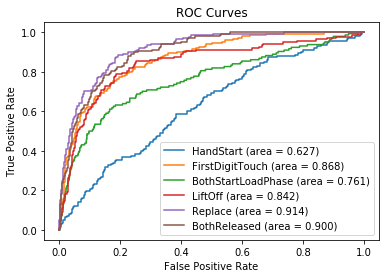

53062 53062
Train subject 12, class HandStart
Train on 1955 samples, validate on 489 samples
Epoch 1/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.8164 - acc: 0.5647 - val_loss: 0.7030 - val_acc: 0.5992
Epoch 2/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.6949 - acc: 0.5882 - val_loss: 0.7094 - val_acc: 0.5828
Epoch 3/100
1955/1955 [==============================] - 1s 327us/step - loss: 0.6736 - acc: 0.6235 - val_loss: 0.6998 - val_acc: 0.5992
Epoch 4/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.6589 - acc: 0.6092 - val_loss: 0.7160 - val_acc: 0.5706
Epoch 5/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.6473 - acc: 0.6153 - val_loss: 0.6308 - val_acc: 0.6339
Epoch 6/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.6387 - acc: 0.6389 - val_loss: 0.6571 - val_acc: 0.6155
Epoch 7/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.6404

Epoch 60/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.4466 - acc: 0.7898 - val_loss: 0.5076 - val_acc: 0.7382
Epoch 61/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.4503 - acc: 0.7872 - val_loss: 0.4764 - val_acc: 0.7669
Epoch 62/100
1955/1955 [==============================] - 1s 335us/step - loss: 0.4368 - acc: 0.8031 - val_loss: 0.4829 - val_acc: 0.7628
Epoch 63/100
1955/1955 [==============================] - 1s 327us/step - loss: 0.4333 - acc: 0.7964 - val_loss: 0.4737 - val_acc: 0.7485
Epoch 64/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.4401 - acc: 0.8046 - val_loss: 0.4730 - val_acc: 0.7873
Epoch 65/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.4431 - acc: 0.7903 - val_loss: 0.4965 - val_acc: 0.7485
Epoch 66/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.4336 - acc: 0.8118 - val_loss: 0.4973 - val_acc: 0.7444
Epoch 67/100
1955/1955 [==========

1955/1955 [==============================] - 1s 331us/step - loss: 0.4053 - acc: 0.8210 - val_loss: 0.4151 - val_acc: 0.8119
Epoch 20/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.3913 - acc: 0.8266 - val_loss: 0.3857 - val_acc: 0.8384
Epoch 21/100
1955/1955 [==============================] - 1s 341us/step - loss: 0.4026 - acc: 0.8189 - val_loss: 0.3924 - val_acc: 0.8282
Epoch 22/100
1955/1955 [==============================] - 1s 333us/step - loss: 0.3909 - acc: 0.8363 - val_loss: 0.3770 - val_acc: 0.8528
Epoch 23/100
1955/1955 [==============================] - 1s 324us/step - loss: 0.3896 - acc: 0.8297 - val_loss: 0.3797 - val_acc: 0.8487
Epoch 24/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.3985 - acc: 0.8251 - val_loss: 0.3870 - val_acc: 0.8384
Epoch 25/100
1955/1955 [==============================] - 1s 335us/step - loss: 0.3909 - acc: 0.8220 - val_loss: 0.4115 - val_acc: 0.8303
Epoch 26/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 333us/step - loss: 0.3286 - acc: 0.8634 - val_loss: 0.3472 - val_acc: 0.8487
Epoch 79/100
1955/1955 [==============================] - 1s 335us/step - loss: 0.3305 - acc: 0.8619 - val_loss: 0.3457 - val_acc: 0.8507
Epoch 80/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.3319 - acc: 0.8634 - val_loss: 0.3651 - val_acc: 0.8384
Epoch 81/100
1955/1955 [==============================] - 1s 327us/step - loss: 0.3290 - acc: 0.8650 - val_loss: 0.3434 - val_acc: 0.8507
Epoch 82/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.3285 - acc: 0.8568 - val_loss: 0.3617 - val_acc: 0.8384
Epoch 83/100
1955/1955 [==============================] - 1s 333us/step - loss: 0.3166 - acc: 0.8742 - val_loss: 0.3260 - val_acc: 0.8671
Epoch 84/100
1955/1955 [==============================] - 1s 333us/step - loss: 0.3252 - acc: 0.8624 - val_loss: 0.3453 - val_acc: 0.8507
Epoch 85/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 333us/step - loss: 0.2611 - acc: 0.8921 - val_loss: 0.2169 - val_acc: 0.9100
Epoch 37/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.2628 - acc: 0.8885 - val_loss: 0.2243 - val_acc: 0.9059
Epoch 38/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.2627 - acc: 0.8977 - val_loss: 0.2164 - val_acc: 0.9162
Epoch 39/100
1955/1955 [==============================] - 1s 333us/step - loss: 0.2491 - acc: 0.9023 - val_loss: 0.2106 - val_acc: 0.9121
Epoch 40/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.2598 - acc: 0.8926 - val_loss: 0.2080 - val_acc: 0.9182
Epoch 41/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.2474 - acc: 0.8972 - val_loss: 0.2090 - val_acc: 0.9141
Epoch 42/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.2469 - acc: 0.9033 - val_loss: 0.2059 - val_acc: 0.9223
Epoch 43/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 338us/step - loss: 0.1651 - acc: 0.9407 - val_loss: 0.1438 - val_acc: 0.9530
Epoch 96/100
1955/1955 [==============================] - 1s 344us/step - loss: 0.1743 - acc: 0.9345 - val_loss: 0.1481 - val_acc: 0.9468
Epoch 97/100
1955/1955 [==============================] - 1s 337us/step - loss: 0.1768 - acc: 0.9345 - val_loss: 0.1444 - val_acc: 0.9509
Epoch 98/100
1955/1955 [==============================] - 1s 354us/step - loss: 0.1729 - acc: 0.9458 - val_loss: 0.1472 - val_acc: 0.9509
Epoch 99/100
1955/1955 [==============================] - 1s 346us/step - loss: 0.1765 - acc: 0.9355 - val_loss: 0.1471 - val_acc: 0.9509
Epoch 100/100
1955/1955 [==============================] - 1s 337us/step - loss: 0.1628 - acc: 0.9427 - val_loss: 0.1427 - val_acc: 0.9530
Train on 1955 samples, validate on 489 samples
Epoch 1/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.1941 - acc: 0.9269 - val_loss: 0.2303 - val_acc: 0.9162


1955/1955 [==============================] - 1s 330us/step - loss: 0.1402 - acc: 0.9468 - val_loss: 0.2489 - val_acc: 0.9202
Epoch 55/100
1955/1955 [==============================] - 1s 327us/step - loss: 0.1309 - acc: 0.9529 - val_loss: 0.2574 - val_acc: 0.9182
Epoch 56/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1324 - acc: 0.9560 - val_loss: 0.2582 - val_acc: 0.9202
Epoch 57/100
1955/1955 [==============================] - 1s 340us/step - loss: 0.1448 - acc: 0.9499 - val_loss: 0.2645 - val_acc: 0.9202
Epoch 58/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.1367 - acc: 0.9545 - val_loss: 0.2637 - val_acc: 0.9182
Epoch 59/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1370 - acc: 0.9529 - val_loss: 0.2442 - val_acc: 0.9202
Epoch 60/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.1311 - acc: 0.9535 - val_loss: 0.2463 - val_acc: 0.9243
Epoch 61/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 339us/step - loss: 0.3960 - acc: 0.8199 - val_loss: 0.3913 - val_acc: 0.8303
Epoch 13/100
1955/1955 [==============================] - 1s 338us/step - loss: 0.3889 - acc: 0.8189 - val_loss: 0.3894 - val_acc: 0.8282
Epoch 14/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.3671 - acc: 0.8389 - val_loss: 0.3865 - val_acc: 0.8364
Epoch 15/100
1955/1955 [==============================] - 1s 335us/step - loss: 0.3725 - acc: 0.8322 - val_loss: 0.3898 - val_acc: 0.8323
Epoch 16/100
1955/1955 [==============================] - 1s 340us/step - loss: 0.3608 - acc: 0.8338 - val_loss: 0.3723 - val_acc: 0.8446
Epoch 17/100
1955/1955 [==============================] - 1s 345us/step - loss: 0.3600 - acc: 0.8358 - val_loss: 0.3701 - val_acc: 0.8487
Epoch 18/100
1955/1955 [==============================] - 1s 344us/step - loss: 0.3450 - acc: 0.8450 - val_loss: 0.3791 - val_acc: 0.8446
Epoch 19/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 328us/step - loss: 0.2024 - acc: 0.9263 - val_loss: 0.2444 - val_acc: 0.9223
Epoch 72/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1945 - acc: 0.9269 - val_loss: 0.2418 - val_acc: 0.9243
Epoch 73/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.1838 - acc: 0.9355 - val_loss: 0.2398 - val_acc: 0.9243
Epoch 74/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1925 - acc: 0.9228 - val_loss: 0.2355 - val_acc: 0.9223
Epoch 75/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.1930 - acc: 0.9289 - val_loss: 0.2382 - val_acc: 0.9264
Epoch 76/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1889 - acc: 0.9320 - val_loss: 0.2334 - val_acc: 0.9264
Epoch 77/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.1819 - acc: 0.9345 - val_loss: 0.2312 - val_acc: 0.9243
Epoch 78/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 327us/step - loss: 0.1869 - acc: 0.9361 - val_loss: 0.2251 - val_acc: 0.9182
Epoch 31/100
1955/1955 [==============================] - 1s 335us/step - loss: 0.1847 - acc: 0.9340 - val_loss: 0.2091 - val_acc: 0.9202
Epoch 32/100
1955/1955 [==============================] - 1s 353us/step - loss: 0.1826 - acc: 0.9350 - val_loss: 0.2108 - val_acc: 0.9182
Epoch 33/100
1955/1955 [==============================] - 1s 362us/step - loss: 0.1784 - acc: 0.9381 - val_loss: 0.2119 - val_acc: 0.9182
Epoch 34/100
1955/1955 [==============================] - 1s 392us/step - loss: 0.1859 - acc: 0.9345 - val_loss: 0.2183 - val_acc: 0.9141
Epoch 35/100
1955/1955 [==============================] - 1s 395us/step - loss: 0.1779 - acc: 0.9407 - val_loss: 0.2053 - val_acc: 0.9264
Epoch 36/100
1955/1955 [==============================] - 1s 354us/step - loss: 0.1841 - acc: 0.9361 - val_loss: 0.2077 - val_acc: 0.9243
Epoch 37/100
1955/1955 [=======================

1955/1955 [==============================] - 1s 332us/step - loss: 0.1376 - acc: 0.9560 - val_loss: 0.1939 - val_acc: 0.9366
Epoch 90/100
1955/1955 [==============================] - 1s 342us/step - loss: 0.1520 - acc: 0.9504 - val_loss: 0.1988 - val_acc: 0.9346
Epoch 91/100
1955/1955 [==============================] - 1s 343us/step - loss: 0.1465 - acc: 0.9519 - val_loss: 0.1885 - val_acc: 0.9366
Epoch 92/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.1514 - acc: 0.9488 - val_loss: 0.1923 - val_acc: 0.9366
Epoch 93/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.1391 - acc: 0.9555 - val_loss: 0.1932 - val_acc: 0.9366
Epoch 94/100
1955/1955 [==============================] - 1s 339us/step - loss: 0.1483 - acc: 0.9535 - val_loss: 0.1906 - val_acc: 0.9387
Epoch 95/100
1955/1955 [==============================] - 1s 356us/step - loss: 0.1456 - acc: 0.9529 - val_loss: 0.1972 - val_acc: 0.9387
Epoch 96/100
1955/1955 [=======================

1956/1956 [==============================] - 1s 326us/step - loss: 0.2586 - acc: 0.8983 - val_loss: 0.3030 - val_acc: 0.8875
Epoch 48/100
1956/1956 [==============================] - 1s 342us/step - loss: 0.2615 - acc: 0.8978 - val_loss: 0.2982 - val_acc: 0.8978
Epoch 49/100
1956/1956 [==============================] - 1s 339us/step - loss: 0.2681 - acc: 0.8916 - val_loss: 0.3018 - val_acc: 0.8916
Epoch 50/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.2539 - acc: 0.9044 - val_loss: 0.3034 - val_acc: 0.8916
Epoch 51/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.2608 - acc: 0.9008 - val_loss: 0.3014 - val_acc: 0.8937
Epoch 52/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.2508 - acc: 0.8983 - val_loss: 0.2912 - val_acc: 0.8978
Epoch 53/100
1956/1956 [==============================] - 1s 339us/step - loss: 0.2407 - acc: 0.9064 - val_loss: 0.2739 - val_acc: 0.9039
Epoch 54/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 330us/step - loss: 0.2489 - acc: 0.9105 - val_loss: 0.2242 - val_acc: 0.9202
Epoch 7/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.2593 - acc: 0.9054 - val_loss: 0.2339 - val_acc: 0.9121
Epoch 8/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.2478 - acc: 0.9049 - val_loss: 0.2264 - val_acc: 0.9182
Epoch 9/100
1956/1956 [==============================] - 1s 332us/step - loss: 0.2501 - acc: 0.9116 - val_loss: 0.2227 - val_acc: 0.9243
Epoch 10/100
1956/1956 [==============================] - 1s 343us/step - loss: 0.2486 - acc: 0.9059 - val_loss: 0.2265 - val_acc: 0.9162
Epoch 11/100
1956/1956 [==============================] - 1s 324us/step - loss: 0.2397 - acc: 0.9100 - val_loss: 0.2311 - val_acc: 0.9141
Epoch 12/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.2458 - acc: 0.9116 - val_loss: 0.2240 - val_acc: 0.9202
Epoch 13/100
1956/1956 [==========================

1956/1956 [==============================] - 1s 332us/step - loss: 0.2003 - acc: 0.9315 - val_loss: 0.2169 - val_acc: 0.9264
Epoch 66/100
1956/1956 [==============================] - 1s 336us/step - loss: 0.1958 - acc: 0.9366 - val_loss: 0.2026 - val_acc: 0.9325
Epoch 67/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1947 - acc: 0.9356 - val_loss: 0.2050 - val_acc: 0.9305
Epoch 68/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1933 - acc: 0.9402 - val_loss: 0.1992 - val_acc: 0.9346
Epoch 69/100
1956/1956 [==============================] - 1s 339us/step - loss: 0.1967 - acc: 0.9361 - val_loss: 0.2082 - val_acc: 0.9284
Epoch 70/100
1956/1956 [==============================] - 1s 334us/step - loss: 0.1875 - acc: 0.9351 - val_loss: 0.2021 - val_acc: 0.9305
Epoch 71/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.2049 - acc: 0.9315 - val_loss: 0.2053 - val_acc: 0.9305
Epoch 72/100
1956/1956 [=======================

Epoch 24/100
1956/1956 [==============================] - 1s 330us/step - loss: 0.2426 - acc: 0.9029 - val_loss: 0.2625 - val_acc: 0.8896
Epoch 25/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.2430 - acc: 0.9029 - val_loss: 0.2354 - val_acc: 0.9059
Epoch 26/100
1956/1956 [==============================] - 1s 323us/step - loss: 0.2433 - acc: 0.9044 - val_loss: 0.2438 - val_acc: 0.8978
Epoch 27/100
1956/1956 [==============================] - 1s 326us/step - loss: 0.2355 - acc: 0.9095 - val_loss: 0.2532 - val_acc: 0.8896
Epoch 28/100
1956/1956 [==============================] - 1s 329us/step - loss: 0.2299 - acc: 0.9187 - val_loss: 0.2635 - val_acc: 0.8814
Epoch 29/100
1956/1956 [==============================] - 1s 333us/step - loss: 0.2284 - acc: 0.9121 - val_loss: 0.2319 - val_acc: 0.9080
Epoch 30/100
1956/1956 [==============================] - 1s 325us/step - loss: 0.2249 - acc: 0.9167 - val_loss: 0.2286 - val_acc: 0.9080
Epoch 31/100
1956/1956 [==========

1956/1956 [==============================] - 1s 343us/step - loss: 0.1704 - acc: 0.9371 - val_loss: 0.1870 - val_acc: 0.9243
Epoch 84/100
1956/1956 [==============================] - 1s 324us/step - loss: 0.1697 - acc: 0.9387 - val_loss: 0.1807 - val_acc: 0.9325
Epoch 85/100
1956/1956 [==============================] - 1s 338us/step - loss: 0.1706 - acc: 0.9387 - val_loss: 0.1849 - val_acc: 0.9305
Epoch 86/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1755 - acc: 0.9356 - val_loss: 0.1861 - val_acc: 0.9264
Epoch 87/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.1723 - acc: 0.9340 - val_loss: 0.1834 - val_acc: 0.9305
Epoch 88/100
1956/1956 [==============================] - 1s 327us/step - loss: 0.1709 - acc: 0.9392 - val_loss: 0.1916 - val_acc: 0.9264
Epoch 89/100
1956/1956 [==============================] - 1s 332us/step - loss: 0.1629 - acc: 0.9453 - val_loss: 0.1793 - val_acc: 0.9305
Epoch 90/100
1956/1956 [=======================

1956/1956 [==============================] - 1s 330us/step - loss: 0.1599 - acc: 0.9458 - val_loss: 0.1708 - val_acc: 0.9550
Epoch 43/100
1956/1956 [==============================] - 1s 334us/step - loss: 0.1601 - acc: 0.9448 - val_loss: 0.1784 - val_acc: 0.9468
Epoch 44/100
1956/1956 [==============================] - 1s 324us/step - loss: 0.1506 - acc: 0.9484 - val_loss: 0.1828 - val_acc: 0.9468
Epoch 45/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1530 - acc: 0.9489 - val_loss: 0.1835 - val_acc: 0.9427
Epoch 46/100
1956/1956 [==============================] - 1s 331us/step - loss: 0.1570 - acc: 0.9458 - val_loss: 0.1842 - val_acc: 0.9427
Epoch 47/100
1956/1956 [==============================] - 1s 328us/step - loss: 0.1564 - acc: 0.9438 - val_loss: 0.1879 - val_acc: 0.9407
Epoch 48/100
1956/1956 [==============================] - 1s 344us/step - loss: 0.1495 - acc: 0.9509 - val_loss: 0.1762 - val_acc: 0.9489
Epoch 49/100
1956/1956 [=======================

1955/1955 [==============================] - 1s 327us/step - loss: 0.7101 - acc: 0.7872 - val_loss: 0.4577 - val_acc: 0.8098
Epoch 2/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.4448 - acc: 0.8205 - val_loss: 0.4415 - val_acc: 0.8098
Epoch 3/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.4083 - acc: 0.8322 - val_loss: 0.3940 - val_acc: 0.8221
Epoch 4/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.4033 - acc: 0.8281 - val_loss: 0.3849 - val_acc: 0.8262
Epoch 5/100
1955/1955 [==============================] - 1s 332us/step - loss: 0.3861 - acc: 0.8404 - val_loss: 0.3830 - val_acc: 0.8241
Epoch 6/100
1955/1955 [==============================] - 1s 326us/step - loss: 0.3671 - acc: 0.8460 - val_loss: 0.3683 - val_acc: 0.8405
Epoch 7/100
1955/1955 [==============================] - 1s 327us/step - loss: 0.3617 - acc: 0.8522 - val_loss: 0.3675 - val_acc: 0.8344
Epoch 8/100
1955/1955 [==============================

1955/1955 [==============================] - 1s 325us/step - loss: 0.2254 - acc: 0.9202 - val_loss: 0.2414 - val_acc: 0.9018
Epoch 61/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.2321 - acc: 0.9146 - val_loss: 0.2293 - val_acc: 0.9100
Epoch 62/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.2307 - acc: 0.9141 - val_loss: 0.2450 - val_acc: 0.9018
Epoch 63/100
1955/1955 [==============================] - 1s 329us/step - loss: 0.2339 - acc: 0.9151 - val_loss: 0.2296 - val_acc: 0.9059
Epoch 64/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.2298 - acc: 0.9141 - val_loss: 0.2372 - val_acc: 0.9018
Epoch 65/100
1955/1955 [==============================] - 1s 326us/step - loss: 0.2229 - acc: 0.9156 - val_loss: 0.2322 - val_acc: 0.9080
Epoch 66/100
1955/1955 [==============================] - 1s 326us/step - loss: 0.2184 - acc: 0.9202 - val_loss: 0.2250 - val_acc: 0.9080
Epoch 67/100
1955/1955 [=======================

Epoch 19/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1938 - acc: 0.9304 - val_loss: 0.2018 - val_acc: 0.9284
Epoch 20/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1931 - acc: 0.9330 - val_loss: 0.1961 - val_acc: 0.9243
Epoch 21/100
1955/1955 [==============================] - 1s 328us/step - loss: 0.1977 - acc: 0.9345 - val_loss: 0.1865 - val_acc: 0.9305
Epoch 22/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1947 - acc: 0.9355 - val_loss: 0.1994 - val_acc: 0.9264
Epoch 23/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1913 - acc: 0.9350 - val_loss: 0.1871 - val_acc: 0.9325
Epoch 24/100
1955/1955 [==============================] - 1s 334us/step - loss: 0.1965 - acc: 0.9381 - val_loss: 0.1864 - val_acc: 0.9325
Epoch 25/100
1955/1955 [==============================] - 1s 346us/step - loss: 0.1968 - acc: 0.9391 - val_loss: 0.1919 - val_acc: 0.9284
Epoch 26/100
1955/1955 [==========

1955/1955 [==============================] - 1s 338us/step - loss: 0.1670 - acc: 0.9458 - val_loss: 0.1827 - val_acc: 0.9346
Epoch 79/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1637 - acc: 0.9422 - val_loss: 0.1787 - val_acc: 0.9325
Epoch 80/100
1955/1955 [==============================] - 1s 324us/step - loss: 0.1652 - acc: 0.9463 - val_loss: 0.1853 - val_acc: 0.9346
Epoch 81/100
1955/1955 [==============================] - 1s 331us/step - loss: 0.1651 - acc: 0.9442 - val_loss: 0.1771 - val_acc: 0.9366
Epoch 82/100
1955/1955 [==============================] - 1s 325us/step - loss: 0.1633 - acc: 0.9442 - val_loss: 0.1821 - val_acc: 0.9346
Epoch 83/100
1955/1955 [==============================] - 1s 323us/step - loss: 0.1678 - acc: 0.9463 - val_loss: 0.1748 - val_acc: 0.9325
Epoch 84/100
1955/1955 [==============================] - 1s 330us/step - loss: 0.1601 - acc: 0.9468 - val_loss: 0.1732 - val_acc: 0.9346
Epoch 85/100
1955/1955 [=======================

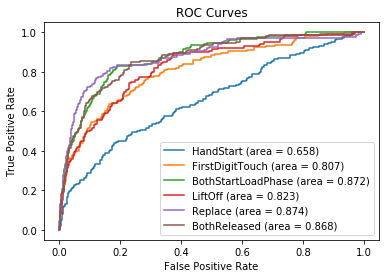

In [19]:


models = []
# for i in range(N_LABELS):
#     models.append(init_cnn(WINDOW_SIZE))
    
models.append(load_model('general_model_HandStart_subject_8.h5'))    
models.append(load_model('general_model_FirstDigitTouch_subject_8.h5'))    
models.append(load_model('general_model_BothStartLoadPhase_subject_8.h5'))    
models.append(load_model('general_model_LiftOff_subject_8.h5'))    
models.append(load_model('general_model_Replace_subject_8.h5'))    
models.append(load_model('general_model_BothReleased_subject_8.h5'))    



for subject in TRAIN_SUBJECTS:
    prediction_total = []
    test_data_total = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]

    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.33, shuffle=False)
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.0001, shuffle=True)
    print(len(x_test), len(y_test))
    
    for i in range(N_LABELS):
        model = models[i]
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        

            
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        
        x = [balanced_x_train[j::2] for j in range(2)]
        y = [train_labels[j::2] for j in range(2)]
        result = np.array([])
        for sample_x, sample_y in zip(x, y):
            model.fit(np.array(sample_x), np.array(sample_y), verbose=1, validation_split=0.2, epochs=EPOCHS)
        
        
        
#         test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)
        

HandStart AUC score = 0.658
FirstDigitTouch AUC score = 0.807
BothStartLoadPhase AUC score = 0.872
LiftOff AUC score = 0.823
Replace AUC score = 0.874
BothReleased AUC score = 0.868


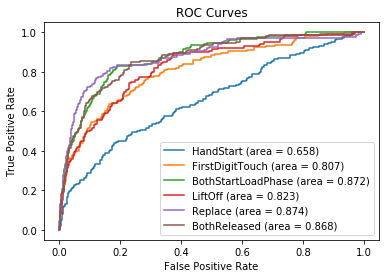

In [20]:
multiple_metric_auc_score(prediction_total, test_data_total, True)